## Improving Water Consumption Management in Barcelona through Data Quality Enhancement and Prediction Models
#### **TFG 2023-2024**
#### **Author: Edith Ruiz Macià**

### Analysis of dataset Dataset2_v2.csv

#### **About the Notebook**

The aim of this notebook (.ipynb) is to analyze and modify the dataset dataset2_v2.csv provided by Aigües de Barcelona in order to improve the quality of the data and learn its insights through its visualization.

The code is structured in different levels.

1. Given the database, we start with an Exploratory Data Analysis that will provide us a general knowledge of how the raw data looks like.
2. Then, an intensive data cleaning will be applied which will transform the data and handle null, negative, and outlier values.
3. We will enhance the data by adding columns that will add up to the understanding of the data and also, by combining outside data that might be relevant to ours.
4. In order to have a complete dataset we will make a projection of absent or incorrect values previously detected in section 2. To do so, we will test several algorithms and see with which one we obtain better results.
5. Anomalies that were previously discarded and substituted by projected values with our predictive model must also be taken into account and analyzed. That is why we will classify and visualize them.

Finally, the updated resulting database can be downloaded in order to be used in other programs or other purposes of the user.

#### ***Execution time***
bla bla bla

#### ***How to execute the code***
This is a Python Notebook, so the code should be run either cell by cell or by running all the notebook at once. At the beginning, review and make sure the paths to all datasets are correct for your folders' distribution in order for everything to run smoothly.

#### ***Libraries and packages used in the project***
bla bla bla

In [1]:
# In case you are working in google colab you can mount your google drive account here
# from google.colab import drive
# drive.mount('/content/drive')

## 0. Importing datasets and libraries

In [2]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [3]:
# Change your path of the data if necessary
dataset2 = 'C:/Users/edith/Desktop/TFG/Datasets/Aigües de Barcelona/Dataset2_V2/dataset2_v2.csv'
dataset2 = pd.read_csv(dataset2)
dataset2.head()

,ID,Diàmetre (mm)/Diámetro (mm)/Diameter (mm),Ús/Uso/Use,Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity,Data/Fecha/Date,Hora/Hora/Time,Consum (L/h)/Consumo (L/h)/Consumption (L/h)
0,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,01:16:35,0.0
1,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,02:16:35,0.0
2,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,03:16:35,0.0
3,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,04:16:35,0.0
4,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,05:16:35,0.0


## 1. Exploratory Data Analysis

As a starting point, we need to explore the data. We analyze the summary of descriptive statistics and plots for each of the datasets in order to detect the corresponding anomalies and subsequently process them correctly.

In [4]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100822 entries, 0 to 2100821
Data columns (total 7 columns):
 #   Column                                                                             Dtype  
---  ------                                                                             -----  
 0   ID                                                                                 object 
 1   Diàmetre (mm)/Diámetro (mm)/Diameter (mm)                                          int64  
 2   Ús/Uso/Use                                                                         object 
 3   Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity  object 
 4   Data/Fecha/Date                                                                    object 
 5   Hora/Hora/Time                                                                     object 
 6   Consum (L/h)/Consumo (L/h)/Consumption (L/h)                                       float64
dtypes: float64(1), int6

In [5]:
dataset2.describe()

,Diàmetre (mm)/Diámetro (mm)/Diameter (mm),Consum (L/h)/Consumo (L/h)/Consumption (L/h)
count,2.100822e+06,2.100822e+06
mean,1.563855e+01,1.868788e+01
std,4.053633e+00,1.006044e+02
min,1.500000e+01,-3.280000e+02
25%,1.500000e+01,0.000000e+00
50%,1.500000e+01,0.000000e+00
75%,1.500000e+01,1.000000e+01
max,6.500000e+01,9.350000e+03


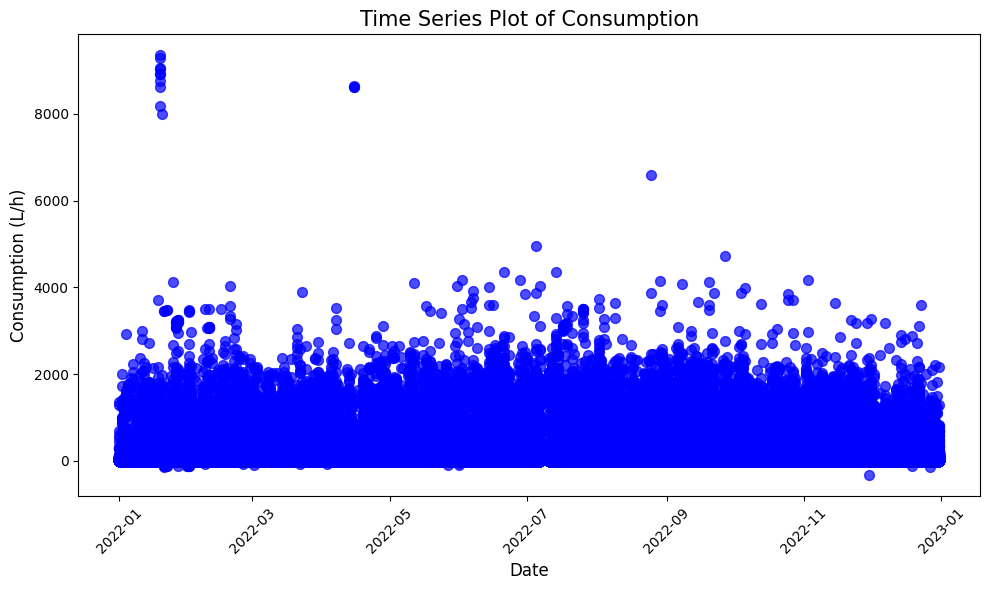

In [6]:
# Consumption over Time
dataset2['Data/Fecha/Date'] = pd.to_datetime(dataset2['Data/Fecha/Date'])
plt.figure(figsize=(10, 6))
plt.scatter(dataset2['Data/Fecha/Date'], dataset2['Consum (L/h)/Consumo (L/h)/Consumption (L/h)'], color='blue', marker='o', s=50, alpha=0.7, label='Data Points')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Consumption (L/h)', fontsize=12)
plt.title('Time Series Plot of Consumption', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

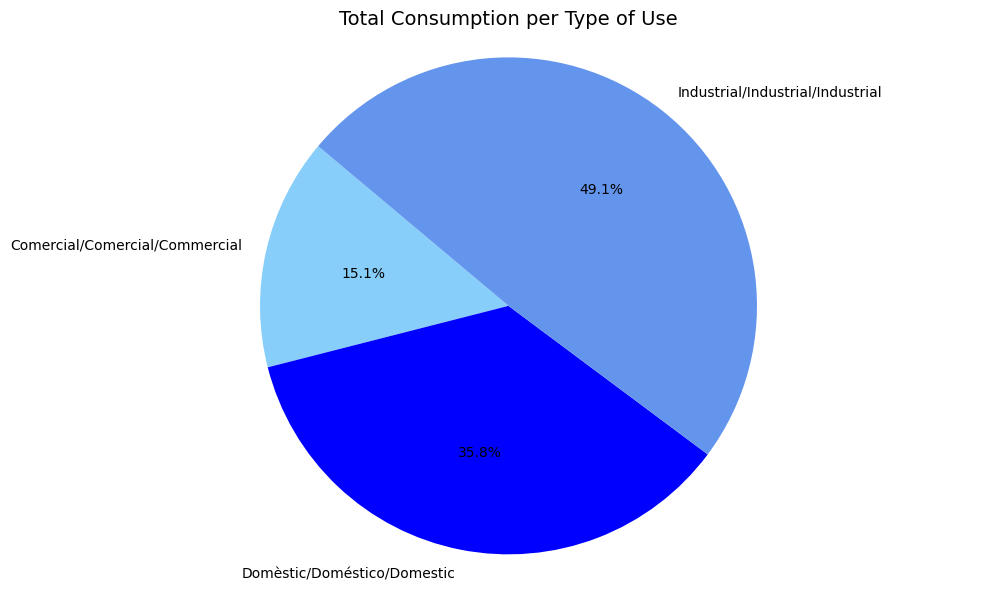

In [7]:
# Aggregate total consumption for each type of use
total_consumption_per_use = dataset2.groupby('Ús/Uso/Use')['Consum (L/h)/Consumo (L/h)/Consumption (L/h)'].sum()
plt.figure(figsize=(10, 6))
total_consumption_per_use.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightskyblue', 'blue', 'cornflowerblue'])
plt.title('Total Consumption per Type of Use', fontsize=14)
plt.ylabel(None)
plt.tight_layout()
plt.axis('equal')
plt.show()

**Insights:**
- There are a significant number of zero values in Consumption. This can affect the performance of the model, especially in linear regression, since the presence of many zeros can affect the assumption of linearity.
- Negative consumption values are considered as incorrect values for the Consumption (L/h) column. Consumption has to be positive.

## 2. Data Preprocessing

##### **2.1. Data Transformation**

In [8]:
# Rename dataset2_v2 columns
new_column_names = {
    'ID': 'ID',
    'Diàmetre (mm)/Diámetro (mm)/Diameter (mm)': 'Diameter (mm)',
    'Ús/Uso/Use': 'Use',
    "Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity": 'Type of economic activity',
    'Data/Fecha/Date': 'Date',
    'Hora/Hora/Time': 'Time',
    'Consum (L/h)/Consumo (L/h)/Consumption (L/h)': 'Consumption (L/h)'
}

dataset2.rename(columns=new_column_names, inplace=True)

In [9]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100822 entries, 0 to 2100821
Data columns (total 7 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   ID                         object        
 1   Diameter (mm)              int64         
 2   Use                        object        
 3   Type of economic activity  object        
 4   Date                       datetime64[ns]
 5   Time                       object        
 6   Consumption (L/h)          float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 112.2+ MB


##### **2.2. Null Values**

In [10]:
# Null values per column
count = 0
columns_dataset2 = dataset2.columns
for column in columns_dataset2:
  print("Column:", column, "- Null values: ", dataset2[column].isnull().sum())

Column: ID - Null values:  0
Column: Diameter (mm) - Null values:  0
Column: Use - Null values:  0
Column: Type of economic activity - Null values:  0
Column: Date - Null values:  0
Column: Time - Null values:  0
Column: Consumption (L/h) - Null values:  0


##### **2.3. Wrong Values**

Now we want to identify the erroneous values in our data. We consider as wrong values the negative consumptions. We will store those values for later analysis.

In [11]:
# We identify negative values in consumption
num_negative_consum_rows = len(dataset2[dataset2['Consumption (L/h)'] < 0])
print("Negative in 'Consumption (L/h)' in the dataset:", num_negative_consum_rows)

Negative in 'Consumption (L/h)' in the dataset: 567


In [12]:
# Copy the negative values into the anomalies dataset for later analysis
anomalies = dataset2[dataset2['Consumption (L/h)'] < 0].copy()
anomalies.head()

,ID,Diameter (mm),Use,Type of economic activity,Date,Time,Consumption (L/h)
255826,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-01-21,03:42:02,-1.0
258447,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-15,08:35:11,-2.0
258476,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-16,13:35:05,-18.0
258749,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-28,18:34:21,-1.0
258989,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-06-08,08:33:38,-1.0


In [13]:
# Replace negative values in Consumption (L/h) by null
dataset2_1 = dataset2.copy()
dataset2_1.loc[dataset2_1['Consumption (L/h)'] < 0, 'Consumption (L/h)'] = np.nan

# Number of negative values in Consumption (L/h) after removing negative values
num_negative_consum_rows2 = len(dataset2_1[dataset2_1['Consumption (L/h)'] < 0])
print("Negative in 'Consumption (L/h)' in the dataset:", num_negative_consum_rows2)

# Number of null values in Consumption (L/h) after removing negative values
print("Number of Nulls in the dataset without negative values:", dataset2_1['Consumption (L/h)'].isnull().sum())

Negative in 'Consumption (L/h)' in the dataset: 0
Number of Nulls in the dataset without negative values: 567


##### **2.4. Outliers**

In [14]:
# Treatment of outliers in Consumption (L/h) with the IQR method

# We separate according to USE: Industrial, Domestic or Commercial
domestic_df = dataset2_1[dataset2_1['Use'].str.contains('Domèstic', case=False, na=False)].copy()
industrial_df = dataset2_1[dataset2_1['Use'].str.contains('Industrial', case=False, na=False)].copy()
comercial_df = dataset2_1[dataset2_1['Use'].str.contains('Comercial', case=False, na=False)].copy()

def outliers_iqr(dataframe):
    global anomalies

    # We compute the IQR for the 'Consumption' column
    consum_col = 'Consumption (L/h)'
    Q1 = dataframe[consum_col].quantile(0.25)
    Q3 = dataframe[consum_col].quantile(0.75)
    IQR = Q3 - Q1

    # We identify the outliers
    outlier_filter = ((dataframe[consum_col] < (Q1 - 1.5 * IQR)) | (dataframe[consum_col] > (Q3 + 1.5 * IQR)))
    
    # Copy the outlier value into the anomalies dataset for later analysis
    outliers = dataframe[outlier_filter].copy()
    anomalies = pd.concat([anomalies, outliers], ignore_index=True)
    
    # And replace them with null
    dataframe.loc[outlier_filter, consum_col] = np.nan

    return dataframe

# We apply the function for each dataframe corresponding to each "Use"
domestic_df = outliers_iqr(domestic_df)
industrial_df = outliers_iqr(industrial_df)
comercial_df = outliers_iqr(comercial_df)

dataset2_filtered = pd.concat([domestic_df, industrial_df, comercial_df], ignore_index=True)

In [15]:
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286754 entries, 0 to 286753
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         286754 non-null  object        
 1   Diameter (mm)              286754 non-null  int64         
 2   Use                        286754 non-null  object        
 3   Type of economic activity  286754 non-null  object        
 4   Date                       286754 non-null  datetime64[ns]
 5   Time                       286754 non-null  object        
 6   Consumption (L/h)          286754 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 15.3+ MB


In [16]:
# Number of null values in Consumption (L/h) prior to removing outliers
print("Number of Nulls in the dataset with outliers but no negatives:", dataset2_1['Consumption (L/h)'].isnull().sum())   #dataset with outliers

# Number of null values in Consumption (L/h) after removing outliers
print("Number of Nulls in the dataset without outliers nor negatives:", dataset2_filtered['Consumption (L/h)'].isnull().sum()) #dataset without outliers

Number of Nulls in the dataset with outliers but no negatives: 567
Number of Nulls in the dataset without outliers nor negatives: 286754


##### **2.5. Storage of Anomalies**

If all anomalies in the data have been cleaned correctly we should have the sum of the number of outlier values and negatives remaining in our anomalies stored.

Negative values removed = 567

Outliers removed = 286754 - 567 = 286187

Total number of anomalies = 286754

In [17]:
# Save current clean dataset for classification of anomalies
clean_data = dataset2_filtered.copy()

anomalies.head()

,ID,Diameter (mm),Use,Type of economic activity,Date,Time,Consumption (L/h)
0,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-01-21,03:42:02,-1.0
1,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-15,08:35:11,-2.0
2,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-16,13:35:05,-18.0
3,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-28,18:34:21,-1.0
4,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-06-08,08:33:38,-1.0


## 3. Data Enhancement


In [43]:
# Convert "Date" and "Time" column to datetime
dataset2_filtered['Date'] = pd.to_datetime(dataset2_filtered['Date'])
dataset2_filtered['Time'] = pd.to_datetime(dataset2_filtered['Time']).dt.time
dataset2_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100822 entries, 0 to 2100821
Data columns (total 7 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   ID                         object        
 1   Diameter (mm)              int64         
 2   Use                        object        
 3   Type of economic activity  object        
 4   Date                       datetime64[ns]
 5   Time                       object        
 6   Consumption (L/h)          float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 112.2+ MB


In [44]:
# We create a new "Day time" column based on the "Time" column
def map_to_time(time):
    hour = time.hour
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 21:
        return 'Afternoon'
    else:
        return 'Night'
    
dataset2_filtered['Day time'] = dataset2_filtered['Time'].map(map_to_time)

# We create a new "Season" column based on the "Date" column
def map_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

dataset2_filtered['Season'] = dataset2_filtered['Date'].dt.month.map(map_to_season)

# We create a new column "Day_of_Week" based on the column "Date"
dataset2_filtered['Day of Week'] = dataset2_filtered['Date'].dt.day_name()

# We create a new column "Month" based on the column "Date"
dataset2_filtered['Month'] = dataset2_filtered['Date'].dt.month

# We create a new column "Year" based on the column "Date"
dataset2_filtered['Year'] = dataset2_filtered['Date'].dt.year

dataset2_filtered.head()

,ID,Diameter (mm),Use,Type of economic activity,Date,Time,Consumption (L/h),Day time,Season,Day of Week,Month,Year
0,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,01:16:35,0.0,Night,Winter,Saturday,1,2022
1,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,02:16:35,0.0,Night,Winter,Saturday,1,2022
2,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,03:16:35,0.0,Night,Winter,Saturday,1,2022
3,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,04:16:35,0.0,Night,Winter,Saturday,1,2022
4,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,05:16:35,0.0,Night,Winter,Saturday,1,2022


As we can see now all data in this dataset is from year 2022. This is important as now we are going to add new information from other datasets and we are going to need the dates to match.

In [45]:
dataset2_filtered['Year'].unique()

array([2022], dtype=int64)

Lets add information to the dataset about the precipitations in Barcelona for the dates of each entrie as well as information about the temperatures. Both precipitation and temperatures should have a strong correlation with the consumed water.

In [46]:
# Change your path of the data if necessary
dataset_rain = 'C:/Users/edith/Desktop/TFG/Datasets/OpenDataBCN/precipitacionsbcndesde1786_2023_long.csv'
dataset_rain = pd.read_csv(dataset_rain)
dataset_rain.head()

,Any,Mes,Desc_Mes,Precipitacions
0,1786,1,Gener,32.8
1,1786,2,Febrer,28.4
2,1786,3,Març,84.4
3,1786,4,Abril,42.3
4,1786,5,Maig,8.5


In [47]:
# Filter the dataset to keep only the desired years
years_to_keep = [2022]
dataset_rain = dataset_rain[dataset_rain['Any'].isin(years_to_keep)]

# Display the first few rows of the filtered dataset
dataset_rain.head()

,Any,Mes,Desc_Mes,Precipitacions
2832,2022,1,Gener,12.3
2833,2022,2,Febrer,1.9
2834,2022,3,Març,89.5
2835,2022,4,Abril,38.9
2836,2022,5,Maig,20.0


In [48]:
def map_to_precipitation(dataset_filtered, dataset_rain):

    # Merge datasets on 'Year' and 'Month'
    merged_data = pd.merge(dataset_filtered, dataset_rain, left_on=['Year', 'Month'], right_on=['Any', 'Mes'], how='left')

    # Drop unnecessary columns from the merged dataset
    merged_data.drop(['Any', 'Mes', 'Desc_Mes'], axis=1, inplace=True)

    return merged_data

dataset2_filtered = map_to_precipitation(dataset2_filtered, dataset_rain)
dataset2_filtered.rename(columns = {'Precipitacions': 'Precipitations'}, inplace=True)
dataset2_filtered.head()

,ID,Diameter (mm),Use,Type of economic activity,Date,Time,Consumption (L/h),Day time,Season,Day of Week,Month,Year,Precipitations
0,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,01:16:35,0.0,Night,Winter,Saturday,1,2022,12.3
1,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,02:16:35,0.0,Night,Winter,Saturday,1,2022,12.3
2,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,03:16:35,0.0,Night,Winter,Saturday,1,2022,12.3
3,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,04:16:35,0.0,Night,Winter,Saturday,1,2022,12.3
4,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,05:16:35,0.0,Night,Winter,Saturday,1,2022,12.3


In [49]:
# Change your path of the data if necessary
dataset_temp = 'C:/Users/edith/Desktop/TFG/Datasets/OpenDataBCN/temperaturesbcndesde1780_2023_long.csv'
dataset_temp = pd.read_csv(dataset_temp)
dataset_temp.head()

,Any,Mes,Desc_Mes,Temperatura
0,1780,1,Gener,6.7
1,1780,2,Febrer,7.3
2,1780,3,Març,11.6
3,1780,4,Abril,11.4
4,1780,5,Maig,16.3


In [50]:
# Filter the dataset to keep only the desired years
years_to_keep = [2022]
dataset_temp = dataset_temp[dataset_temp['Any'].isin(years_to_keep)]

# Display the first few rows of the filtered dataset
dataset_temp.head()

,Any,Mes,Desc_Mes,Temperatura
2904,2022,1,Gener,10.2
2905,2022,2,Febrer,11.8
2906,2022,3,Març,10.8
2907,2022,4,Abril,14.1
2908,2022,5,Maig,20.7


In [51]:
def map_to_temperature(dataset_filtered, dataset_temp):

    # Merge datasets on 'Year' and 'Month'
    merged_data = pd.merge(dataset_filtered, dataset_temp, left_on=['Year', 'Month'], right_on=['Any', 'Mes'], how='left')

    # Drop unnecessary columns from the merged dataset
    merged_data.drop(['Any', 'Mes', 'Desc_Mes'], axis=1, inplace=True)

    return merged_data

dataset2_filtered = map_to_temperature(dataset2_filtered, dataset_temp)
dataset2_filtered.rename(columns = {'Temperatura': 'Temperature'}, inplace=True)
dataset2_filtered.head()

,ID,Diameter (mm),Use,Type of economic activity,Date,Time,Consumption (L/h),Day time,Season,Day of Week,Month,Year,Precipitations,Temperature
0,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,01:16:35,0.0,Night,Winter,Saturday,1,2022,12.3,10.2
1,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,02:16:35,0.0,Night,Winter,Saturday,1,2022,12.3,10.2
2,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,03:16:35,0.0,Night,Winter,Saturday,1,2022,12.3,10.2
3,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,04:16:35,0.0,Night,Winter,Saturday,1,2022,12.3,10.2
4,d6820111d10fcde14bf3fb393cc188d5c684b073797453...,15,Domèstic/Doméstico/Domestic,<NULL>/ <NULL>/ <NULL>,2022-01-22,05:16:35,0.0,Night,Winter,Saturday,1,2022,12.3,10.2


## 4. Data Prediction

##### **4.1. Linear**

In order to do the projection of incorrect values (negative and outliers) that right now happen to be null values in the dataset, we will implement several data prediction models, compare their results and conclude which gives the best results for our data.

We will now encode the variables that aren't numerical in order to work with them and plot a correlation matrix to see which features explain best our target variable, Accumulated Consumption (L/day).

In [52]:
# Convert "Date" column to object for label encoding
dataset2_filtered['Date'] = dataset2_filtered['Date'].astype(object)
dataset2_filtered['Time'] = dataset2_filtered['Time'].astype(object)

In [53]:
# Label Encoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column containing categorical data
for column in dataset2_filtered.columns:
    if dataset2_filtered[column].dtype == 'object':
        dataset2_filtered[column] = label_encoder.fit_transform(dataset2_filtered[column])

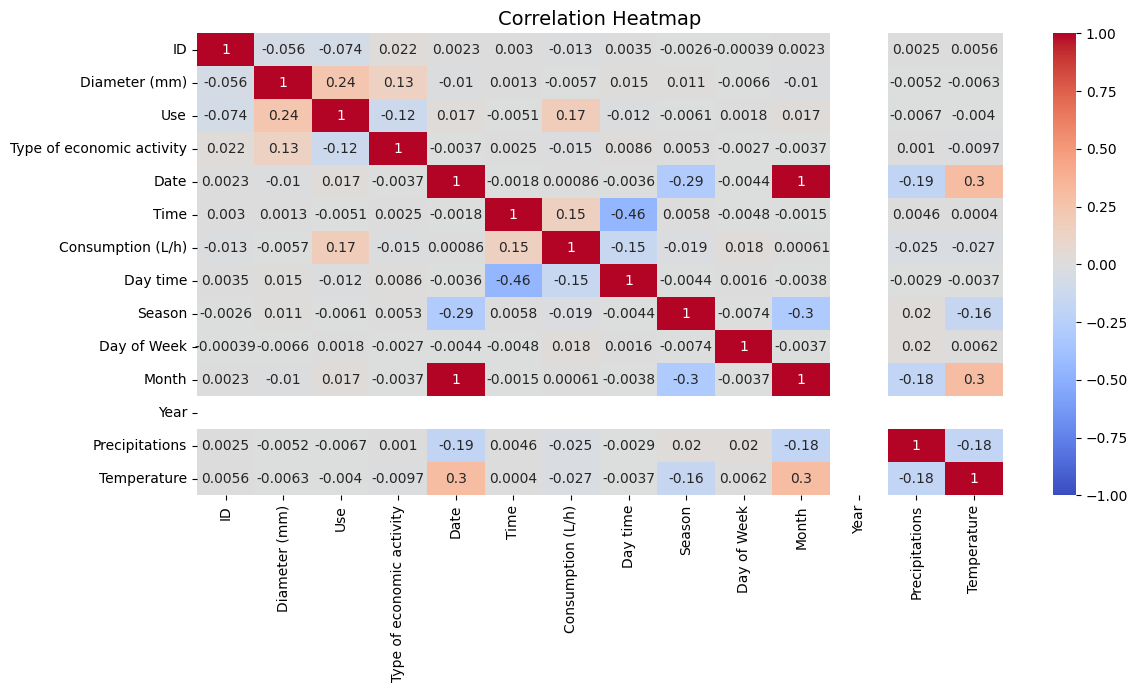

In [54]:
dataset2_filtered_not_null = dataset2_filtered[~dataset2_filtered['Consumption (L/h)'].isnull()]
corr = dataset2_filtered_not_null.corr()
plt.figure(figsize=(13,6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 14})
plt.show()

In [59]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset2_filtered2 = dataset2_filtered.dropna(subset=['Consumption (L/h)'])

# Independent variables
features = ['Use', 'Time', 'Season', 'Day of Week', 'Type of economic activity']

X = dataset2_filtered2[features]

# Target variable (dependent variable)
y = dataset2_filtered2['Consumption (L/h)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 1451254
Length y_train: 1451254
Lenght X_test: 362814
Length y_test: 362814


##### **4.1. Linear Regression**

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evalute the model
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error (MSE): {round(np.sqrt(mse_lr), 4)}")
print(f"Linear Regression Mean Absolute Error (MAE): {round(mae_lr, 4)}")
print(f"Linear Regression R-squared (R2): {round(r2_lr, 4)}")

##### **4.2. Random Forest**

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE):", round(np.sqrt(mse_rf), 4))
print(f"Random Forest Mean Absolute Error (MAE): {round(mae_rf, 4)}")
print(f"Random Forest R-squared (R2):", round(r2_rf, 4))

##### **4.3. XGBoost**

In [60]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error (MSE):", round(np.sqrt(mse_xgb), 4))
print(f"XGBoost Mean Absolute Error (MAE): {round(mae_xgb, 4)}")
print(f"XGBoost R-squared (R2):", round(r2_xgb, 4))

XGBoost Mean Squared Error (MSE): 5.6259
XGBoost Mean Absolute Error (MAE): 3.7538
XGBoost R-squared (R2): 0.2613


##### **4.4. K-Nearest Neighbors**

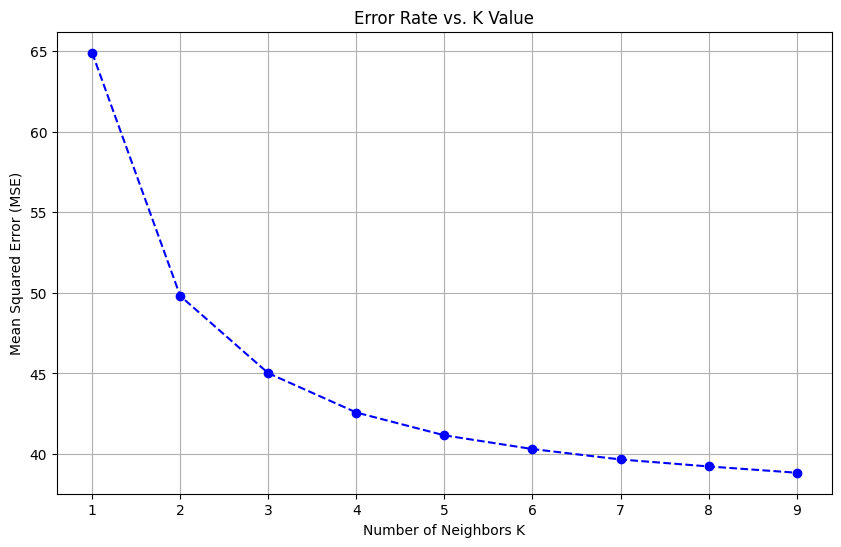

The best k value is: 9


In [61]:
# Range of k values to test
k_values = range(1, 10)
mse_values = []

# Evaluation of the model for each k value
for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_knn)
    mse_values.append(mse)

# Plot error rates vs k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', linestyle='dashed', color='b')
plt.xlabel('Number of Neighbors K', fontsize=10)
plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
plt.title('Error Rate vs. K Value', fontsize=12)
plt.xticks(k_values)
plt.grid(True)
plt.show()

# k value with the minimum error rate
best_k = k_values[np.argmin(mse_values)]
print(f"The best k value is: {best_k}")

In [62]:
# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=9)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"K-Nearest Neighbors Mean Squared Error (MSE):", round(np.sqrt(mse_knn), 4))
print(f"K-Nearest Neighbors Mean Absolute Error (MAE): {round(mae_knn, 4)}")
print(f"K-Nearest Neighbors R-squared (R2):", round(r2_knn, 4))

K-Nearest Neighbors Mean Squared Error (MSE): 6.232
K-Nearest Neighbors Mean Absolute Error (MAE): 4.0528
K-Nearest Neighbors R-squared (R2): 0.0935


##### **4.5. Support Vector Machine**

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset2_filtered2 = dataset2_filtered.dropna(subset=['Consumption (L/h)'])

# Reduce the working dataset
rows = len(dataset2_filtered2) // 10
dataset2_filtered2 = dataset2_filtered2.iloc[:rows]

# Independent variables
features = ['Use', 'Time', 'Season', 'Day of Week', 'Type of economic activity']
X = dataset2_filtered2[features]

# Target variable (dependent variable)
y = dataset2_filtered2['Consumption (L/h)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

In [ ]:
# Support Vector Machine
svm_model = SVR()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"Support Vector Machine Mean Squared Error (MSE):", round(np.sqrt(mse_svm), 4))
print(f"Support Vector Machine Mean Absolute Error (MAE): {round(mae_svm, 4)}")
print(f"Support Vector Machine R-squared (R2):", round(r2_svm, 4))

##### **4.6. Explainability**

##### **4.7. Conclusions on Data Prediction Algorithms**

Based on the R-squared values obtained per each model I conclude that 0.2791 is the least worse model for dataset1_v2.csv data. It is considered a good model if the R-squared value is higher than 0.9, therefore non of the aboce are good models. Anyway, we will replace the missing values with the predictions of this model. We have already trained model so now we replace all null values.

In [ ]:
# Identifiquem les files amb valor Null en 'Consumption (L/h)'
missing_rows = dataset2_filtered[dataset2_filtered['Consumption (L/h)'].isnull()]

features2 = ['Use', 'Time', 'Temperature', 'Precipitations', 'Season', 'Day of Week', 'Diameter (mm)', 'Type of economic activity', 'Date']
X_ = missing_rows[features2]

# Predim els valors amb el model
predicted_values = xgb_model.predict(X_)

dataset2_filtered.loc[missing_rows.index, 'Consumption (L/h)'] = predicted_values

We now check that no null values nor negatives are in the dataset.

In [ ]:
# Number of null values in Consumption (L/h)
print("Number of Nulls in the dataset:", dataset2_filtered['Consumption (L/h)'].isnull().sum())

# Number of negatives values in Consumption (L/h)
print("Number of Negatives in the dataset:", len(dataset2_filtered[dataset2_filtered['Consumption (L/h)'] < 0]))

Lets visualize the Consumption after having cleaned and projected the incorrect values.

In [ ]:
# PLOTS

## 5. Analysis of anomalies

##### **5.1. Classification Criteria**

Previously, we stored all anomalies for later analysis. We are now going to state a classification criteria in order to classify said anomalies into 3 categories: leak or waste, system error or correct but misclassified.
This classification is based on the average of the correct real data, I'm not using the predicted one by the models but it might not be very accurate. This should be done with specific data portraying leaks, waste and system errors.

In [26]:
# % of anomalies with respect to the original dataset
percentage = (286754 / 2100822 ) * 100
print("% of anomalies with respect to the original dataset: ", round(percentage, 2), "%")

% of anomalies with respect to the original dataset:  13.65 %


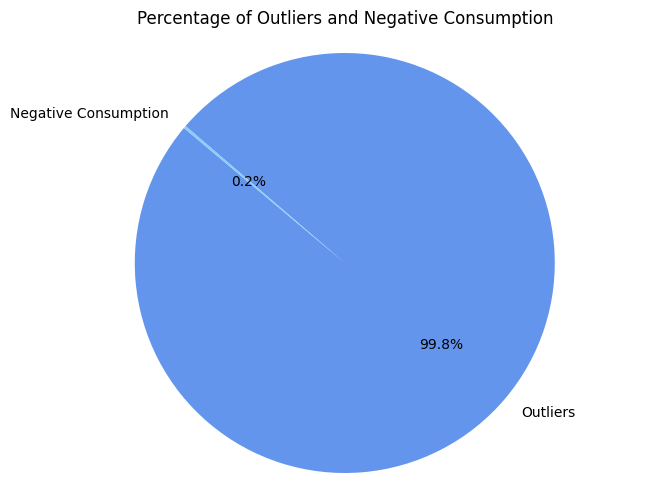

In [18]:
# Count of Outliers and Negative values
outliers_count = (anomalies['Consumption (L/h)'] > 0).sum()
negative_count = (anomalies['Consumption (L/h)'] < 0).sum()

total_count = len(anomalies)
outliers_percentage = (outliers_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

labels = ['Outliers', 'Negative Consumption']
sizes = [outliers_percentage, negative_percentage]
colors = ['cornflowerblue', 'lightskyblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Outliers and Negative Consumption')
plt.axis('equal')
plt.show()

Now we compute the minimum, average and maximum values per type of Use so we can classify each values accordingly.

In [19]:
# For each type of Use we can compute the min, average and max values
grouped_data = clean_data.groupby('Use')['Consumption (L/h)'].agg(['min', 'mean', 'max'])

# Accessing min, average, and max values for a specific 'Use' type
use_type = 'Domèstic/Doméstico/Domestic'
domestic_min = grouped_data.loc[use_type, 'min']
domestic_average = grouped_data.loc[use_type, 'mean']
domestic_max = grouped_data.loc[use_type, 'max']

use_type = 'Comercial/Comercial/Commercial'
commercial_min = grouped_data.loc[use_type, 'min']
commercial_average = grouped_data.loc[use_type, 'mean']
commercial_max = grouped_data.loc[use_type, 'max']

use_type = 'Industrial/Industrial/Industrial'
industrial_min = grouped_data.loc[use_type, 'min']
industrial_average = grouped_data.loc[use_type, 'mean']
industrial_max = grouped_data.loc[use_type, 'max']

grouped_data

,min,mean,max
Use,,,
Comercial/Comercial/Commercial,0.0,1.478104,15.0
Domèstic/Doméstico/Domestic,0.0,4.021802,27.0
Industrial/Industrial/Industrial,0.0,4.909791,47.0


##### **5.2. Anomalies classification**

The following function gets the anomalies dataset and depending on the type of Use applies a classification. I considered consumption values over the maximum value to be of type 'Leak or Waste'. If the consumption is negative then I consider this a 'Data Collection System Error' and in case of not belonging in any of these two groups then the value would be 'Correct but Misclassified'.

In [20]:
def anomalies_classification(dataset_anomalies):
    if dataset_anomalies['Use'] == 'Domèstic/Doméstico/Domestic':
        if dataset_anomalies['Consumption (L/h)'] > domestic_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Consumption (L/h)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Comercial/Comercial/Commercial':
        if dataset_anomalies['Consumption (L/h)'] > commercial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Consumption (L/h)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Industrial/Industrial/Industrial':
        if dataset_anomalies['Consumption (L/h)'] > industrial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Consumption (L/h)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
    

anomalies['Classification'] = anomalies.apply(anomalies_classification, axis=1)
anomalies.head()

,ID,Diameter (mm),Use,Type of economic activity,Date,Time,Consumption (L/h),Classification
0,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-01-21,03:42:02,-1.0,Data Collection System Error
1,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-15,08:35:11,-2.0,Data Collection System Error
2,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-16,13:35:05,-18.0,Data Collection System Error
3,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-05-28,18:34:21,-1.0,Data Collection System Error
4,25dad700550a3792c875e4fcbfb990067748c5b760b8e8...,15,Comercial/Comercial/Commercial,"* de vehicles automòbils, bicicletes i altres/...",2022-06-08,08:33:38,-1.0,Data Collection System Error


Now we can visualize the new classification in total and per type of Use.

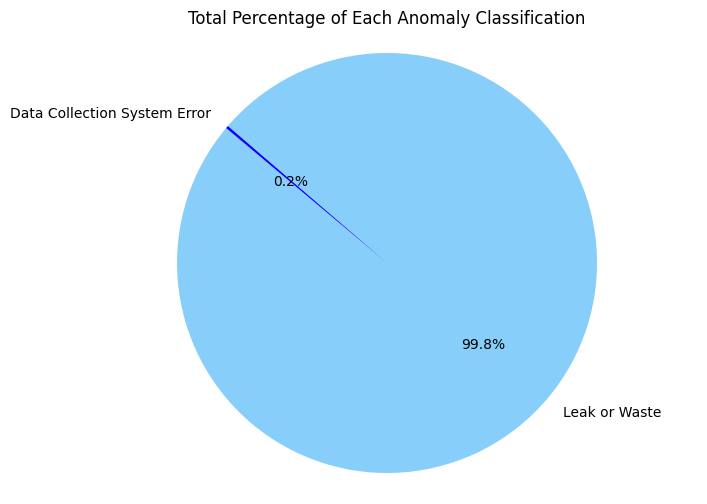

In [21]:
# Count occurrences of each classification
classification_counts = anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Total Percentage of Each Anomaly Classification')
plt.axis('equal')
plt.show()

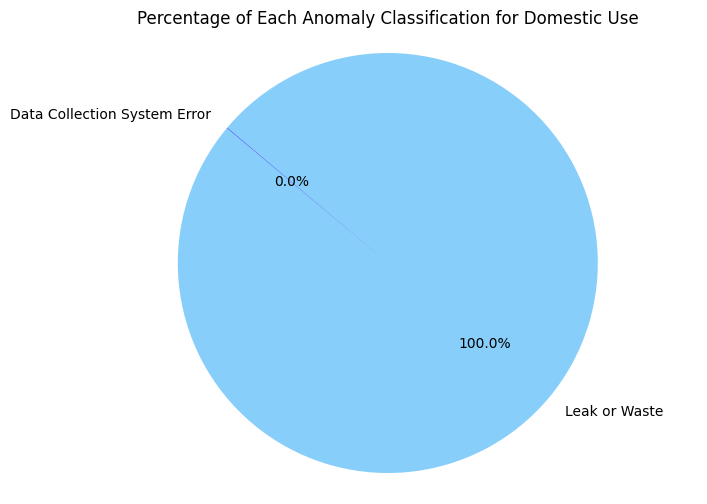

In [22]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Domèstic/Doméstico/Domestic']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue'] 

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Domestic Use')
plt.axis('equal')
plt.show()

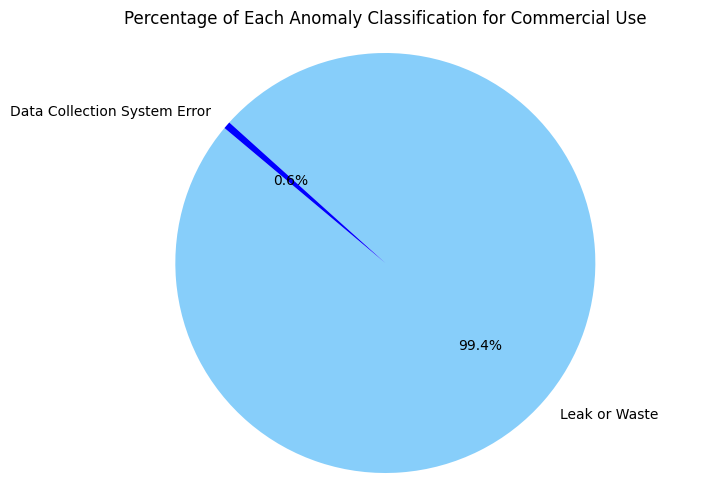

In [23]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Comercial/Comercial/Commercial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Commercial Use')
plt.axis('equal') 
plt.show()

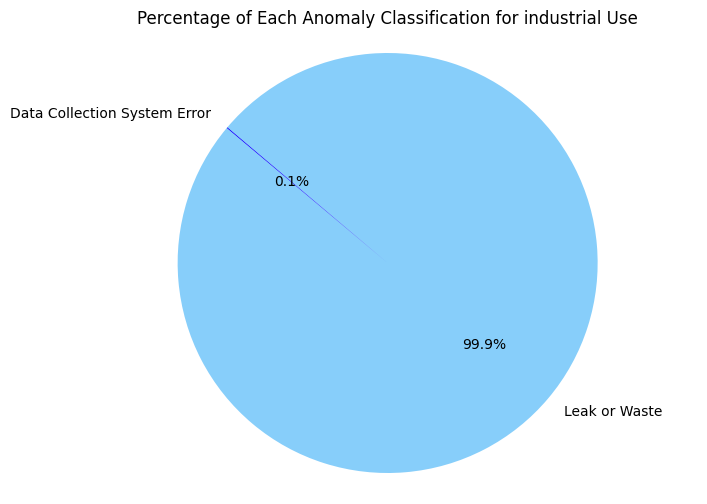

In [24]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Industrial/Industrial/Industrial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for industrial Use')
plt.axis('equal')
plt.show()

In [ ]:
# Download anomalies
anomalies.to_csv('anomalies_dataset2_v2.csv', index=False)

## 6. Export improved data



In [ ]:
dataset2_filtered.to_csv('updated_dataset2_v2.csv', index=False)